# Experiment 0530 - using eric FP dataset 100 questions

In [ ]:
# dependency
%pip install python-dotenv
%pip install openai
%pip install pandas

In [1]:
import os
from dotenv import load_dotenv, find_dotenv # load keys from .env file
import openai # use OpenAI API
import random
import json
import pandas as pd
import numpy as np
import datetime

_ = load_dotenv(find_dotenv()) # read local .env file
openai.api_key  = os.getenv('OPENAI_API_KEY')

In [2]:
def get_completion(prompt, model="gpt-3.5-turbo"):
    messages = [{"role": "user", "content": prompt}]
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=0, # this is the degree of randomness of the model's output
        max_tokens=600, # this is the maximum number of tokens to generate
    )
    print(">>>>RESPONSE>>>>")
    print(str(response.choices[0].message["content"]))
    print("<<<<END<<<<")
    return response.choices[0].message["content"]

## Prompt Design (3rd iteration)

In [3]:
# We selected prompt 1 ,2 , 4 for our experiment
# prompt 1 - competence prompt: (simple instruction + 0-shot)
def prompt_1(question):
    return f"""\
TASK: A curious learner will ask you a question:
You know the answer in the order of magnitude. You will teach the learner, step by step, \
how they can work out an estimated answer themselves. You are allowed to make assumptions. Answer in the order of magnitude (10^x) and report value of x in ANSWER. \

QUESTION: {question}
REASON: [your reason]
ESTIMATED VALUE: 10^[your answer]
"""

# prompt 4 - with more classic examples (simple context and examples generated by LLM + 3-shot)
def prompt_4(question):
    return f"""\
You are providing a Fermi estimation for a given question. Show your assumptions, calculations, and the final estimated value in the order of magnitude (expressed in 10^n). Follow the examples to answer an estimation question after  ------.
Example 1:
**Please provide a Fermi estimation for this question: How many soccer balls would fit inside the Eiffel Tower?**
RESPONSE:
**Assumptions**: Assume the Eiffel Tower is a cylinder with a height of 300m and base diameter of 100m. Assume a standard soccer ball has a diameter of 22cm.
**Calculations**: Calculate the volume of the Eiffel Tower using the formula for a cylinder, πr²h, and divide by the volume of a soccer ball, 4/3*πr³. Compensate for the packing efficiency of spheres in a space, typically around 0.74.
**Estimated Value**: The estimated value is in the order of magnitude of 10^7 soccer balls.

Example 2:

**Please provide a Fermi estimation for this question: How many grains of sand are there on a typical beach?**
RESPONSE:
**Assumptions**: Assume a typical beach is 1km long, 100m wide, and the sand is 1m deep. Assume a grain of sand is about 0.5mm in diameter.
**Calculations**: Calculate the volume of the beach, multiply by the density of sand, and then divide by the volume of a grain of sand. Again, compensate for the packing efficiency of spheres, typically around 0.64.
**Estimated Value**: The estimated value is in the order of magnitude of 10^15 grains of sand.

Example 3:

**Please provide a Fermi estimation for this question: How many piano tuners are there in New York City?**
RESPONSE:
**Assumptions**: Assume the population of New York City is 8 million. Assume that on average, one in 800 people own a piano. Assume a piano needs to be tuned once a year, and one tuner can tune a piano in 2 hours and works 2000 hours a year.
**Calculations**: Calculate the total number of pianos in New York City by multiplying the population by the ratio of piano owners. Then, calculate how many pianos a single tuner can tune in a year. Divide the total number of pianos by this to get the number of tuners.
**Estimated Value**: The estimated value is in the order of magnitude of 10^2 piano tuners.
------

**Please provide a Fermi estimation for this question: {question}**
RESPONSE:
"""

## Load database and clean

In [4]:
# using the Eric FP database

with open('Eric_FP_suggestion.json', 'r', encoding='utf-8') as f:
    data = json.load(f)
    print("No. of Questions: " + str(len(data)))

df = pd.DataFrame(data)

# some pre-processing to understand the data
df['answer'] = pd.to_numeric(df['answer'], errors='coerce')
# consistent naming from experiment 3
df = df.rename(columns={'name': 'Question', 'answer': 'Answer', 'unit': 'Unit'})

# remove extreme values
print(df[df['Answer'] <-50 ]) # extremely small values
print(df[df['Answer'] > 50 ]) # extremely large values
filtered_df = df[df['Answer'].between(-50, 50)]


No. of Questions: 278
       id                                           Question  Answer  Unit
248  1248  What is the probability that you will end up w...     -68  None
       id                                           Question  Answer  \
22   1022  Archimedes famously placed an upper bound on t...      63   
170  1170                                            125! =      209   
185  1185                                             8^88 =      79   
199  1199                    What is 137 to the power of 56?     119   
200  1200           How many electrons are there in our Sun?      57   
216  1216  Under favorable conditions, the bacterium SO (...     433   
249  1249     Calculate 10^100 - 10^99 - 10^98 - ... - 10^1.     100   
252  1252  Compute 2<sup>2<sup>2<sup>2<sup>2</sup></sup><...   19728   
256  1256                                     What is 75^56?     105   

               Unit  
22   grains of sand  
170            None  
185            None  
199            None

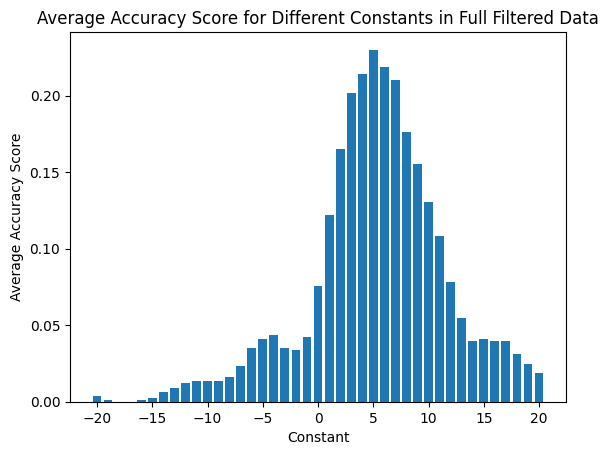

0.2300995024875622


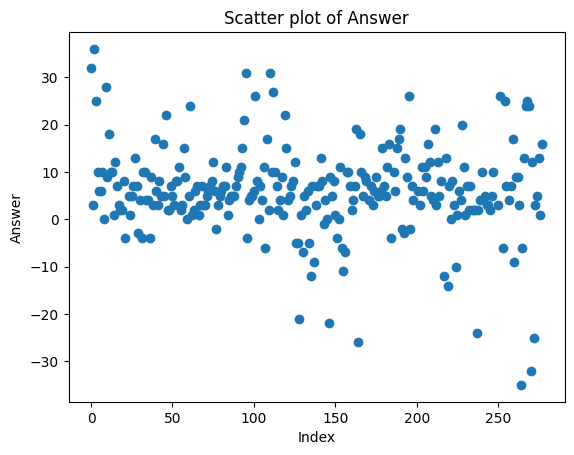

In [63]:
# check answer against a constant (e,g, 10^2)
# Define your constant
x = 3

# Define your self-defined function
def calculate_difference(answer, x):
    try:
        return calculate_performance_score(float(answer) - x)
    except ValueError:
        return None

def calculate_performance_score(difference):
    try:
        return max(0, 1 - abs(difference) / 3)
    except ValueError:
        return None

# Apply the function to the 'answer' column
# print(copy[["Answer","Score"]])

# sweep through (10^-10 to 10^10) to obtain the best guess distribution

def sweep_score(df, min:int =-20, max:int = 20):
    sweep_score = []
    for x in range(min, max+1):
        copy = df.copy()
        new_col = f"Score_constant_{x}"
        copy[new_col] = df["Answer"].apply(lambda answer: calculate_difference(answer, x))
        average_PI = copy[new_col].mean()
        # print(f"The average difference for constant {x} is: ", average_PI)
        sweep_score.append(average_PI)
    return sweep_score

# plot the sweep score in bar chart
import matplotlib.pyplot as plt

sweep_score_for_full_data = sweep_score(filtered_df)
# plot the sweep score in bar chart
plt.bar(range(-20, 21), sweep_score_for_full_data)
plt.xlabel("Constant")
plt.ylabel("Average Accuracy Score")
plt.title("Average Accuracy Score for Different Constants in Full Filtered Data")
plt.show()

print(max(sweep_score_for_full_data))

plt.scatter(filtered_df.index, filtered_df['Answer'])
plt.title('Scatter plot of Answer')
plt.xlabel('Index')
plt.ylabel('Answer')
plt.show()


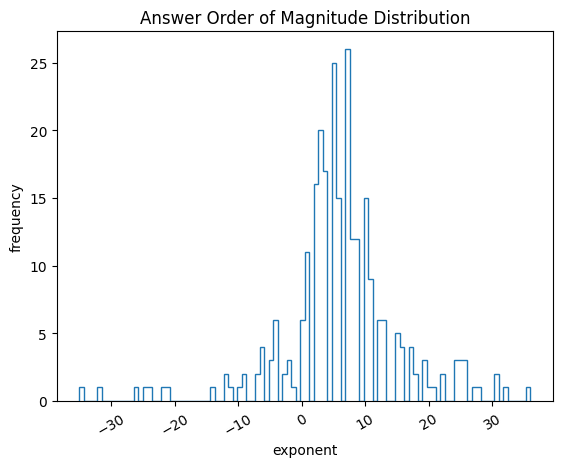

In [65]:
plt.hist(filtered_df["Answer"], 100, histtype='step')
plt.title('Answer Order of Magnitude Distribution')
plt.xlabel('exponent')
plt.ylabel('frequency')
plt.xticks(rotation=30)
plt.show()

### Experiment with sampled data

In [5]:
# Get the current date and time
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

prompt_list = [prompt_1, prompt_4]

def inference(row, prompt, model='gpt-3.5-turbo', num_trials=3):
    # if row or prompt are not defined or empty, return None
    question = row['Question']
    if not question or not prompt:
        return None
    for i in range(num_trials): # default max 3 trials
        try:
            # Assuming that get_completion function returns the answer
            return get_completion(prompt(question), model=model)
        except Exception as e:
            print(f"Encountered an error at question {row.name} in trial {i+1}: {e}")
            # If it's the last trial, don't try again
            if i == num_trials - 1:
                return "ERROR"
            else:
                print("Retrying...")
            # Add 'ERROR' to the results dictionary 

result_data = filtered_df.copy()

import time
time_taken_for_each_round = []
# iterate through each question in sampled question list with prompt 1-4
prompt_list_index = [1,4]
for index in range(len(prompt_list_index)):
    if index == 1:
        pass
    starting_time = time.time()
    experiment_prompt = prompt_list[index]
    prompt_index = prompt_list_index[index]
    result_data[f"Prompt_{prompt_index}_result"] = filtered_df.apply(lambda row: inference(row, experiment_prompt, model="gpt-3.5-turbo"), axis=1)
    time_taken_for_each_round.append(time.time() - starting_time)
    print(f"COMPLELETD PROMPT {prompt_index}")
    # save data to csv with timestamp for post analysis
    csv_filename = f"est_out_prompt_{prompt_index}_{timestamp}.csv"
    result_data.to_csv(csv_filename, index=False)

# print out time taken for each round
for i in range(len(time_taken_for_each_round)):
    print(f"round {i+1} time taken: {time_taken_for_each_round[i]} seconds")

print(f"total time taken: {sum(time_taken_for_each_round)} seconds")


>>>>RESPONSE>>>>
First, we need to know the approximate size of Madagascar. Let's assume it is roughly the size of Texas, which is approximately 700,000 square kilometers. 

Next, we need to convert square kilometers to square angstroms. One square kilometer is equal to 1 x 10^20 square angstroms. 

So, the estimated area of Madagascar in square angstroms would be:

700,000 square kilometers x 1 x 10^20 square angstroms/square kilometer = 7 x 10^25 square angstroms

ANSWER: 10^25
<<<<END<<<<
>>>>RESPONSE>>>>
Assumption: The height of the tallest building in the world is around 2,700 feet.

To estimate the height of the 22nd tallest building in the world, we can use the fact that the height of buildings generally decreases as we move down the list of tallest buildings. 

Assuming a rough average decrease of 100 feet in height for each building as we move down the list, we can estimate that the 22nd tallest building in the world is around 1,800 feet tall.

Therefore, the estimated value 

In [95]:
# once the answer is obtained, manual labeling is required to determine if the answer is correct or not
df = pd.read_csv(f"./labelled_eric_prompt_1_output_20230531-145132.csv") # vulnerable! timestamp may not be consistent

# Convert columns 3 and 6 to numeric, errors='coerce' turns non-numeric values into NaN
df.iloc[:, [2, 5,6]] = df.iloc[:, [2, 5,6]].apply(pd.to_numeric, errors='coerce')

print(df.head())

       id                                           Question  Answer   
0  1000.0  What is the area of Madagascar, in square angs...    32.0  \
1  1001.0  How tall, in feet, is the 22nd tallest buildin...     3.0   
2  1002.0                                      What is 7^43?    36.0   
3  1003.0             What is the mass of Mars in iPhone 5s?    25.0   
4  1004.0  How many Apps have been downloaded from Apple'...    10.0   

               Unit                                    Prompt_1_result   
0  square angstroms  First, we need to know the approximate size of...  \
1              feet  Assumption: The height of the tallest building...   
2               NaN  To estimate the value of 7^43, we can use the ...   
3         iPhone 5s  ANSWER: \n\nAssuming that the learner is askin...   
4              Apps  ANSWER: \n\nAssuming that the question is refe...   

  Prompt_1_answer Prompt_1_score  
0            25.0            0.0  
1             3.0            1.0  
2            40.0

In [96]:

def calculate_score(truth, model_guess):
    difference = abs(truth - model_guess)
    # score = 0
    # if (difference < 0.0001):
    #     score = 3
    # elif (difference < 1.0001):
    #     score = 2
    # elif (difference < 2.0001):
    #     score = 1
    # else:
    #     score = 0 # this will give NaN also 0
    # return score / 3      
    return max(0, 1 - abs(truth - model_guess) / 3)
  

# Calculate performance score based on ground truth (col 3) and average (col 6)
# and store the value in the 'Performance_Score' column
df['Performance_Score'] = df.apply(lambda row: calculate_score(row[2], row[5]), axis=1)
print(df.head())
# output the average performance score
print(f"Average performance score: {df['Performance_Score'].mean()}") # this is different from excel calculation

# # save the dataframe to csv
# df.to_csv(f"./labelled_eric_output_20230531-145132.csv", index=False)


       id                                           Question  Answer   
0  1000.0  What is the area of Madagascar, in square angs...    32.0  \
1  1001.0  How tall, in feet, is the 22nd tallest buildin...     3.0   
2  1002.0                                      What is 7^43?    36.0   
3  1003.0             What is the mass of Mars in iPhone 5s?    25.0   
4  1004.0  How many Apps have been downloaded from Apple'...    10.0   

               Unit                                    Prompt_1_result   
0  square angstroms  First, we need to know the approximate size of...  \
1              feet  Assumption: The height of the tallest building...   
2               NaN  To estimate the value of 7^43, we can use the ...   
3         iPhone 5s  ANSWER: \n\nAssuming that the learner is askin...   
4              Apps  ANSWER: \n\nAssuming that the question is refe...   

  Prompt_1_answer Prompt_1_score  Performance_Score  
0            25.0            0.0           0.000000  
1             

## Result inspection and data analysis

In [100]:
#inspect data where 'Performance_Score' is effectively 0.00
zero_score_rows = df[df['Performance_Score'] <= 0.00001]
pd.set_option('display.max_colwidth', 30)  # or 199
print(zero_score_rows)

         id                       Question  Answer                      Unit   
0    1000.0  What is the area of Madaga...    32.0          square angstroms  \
2    1002.0                  What is 7^43?    36.0                       NaN   
3    1003.0  What is the mass of Mars i...    25.0                 iPhone 5s   
9    1009.0  How many atoms are in your...    28.0                     atoms   
13   1013.0  If you were to count from ...    10.0                     years   
..      ...                            ...     ...                       ...   
264  1274.0  How many standard AAA batt...     5.0                 batteries   
265  1275.0  How many cells are in the ...    13.0                     cells   
266  1276.0  If every person who ever l...     1.0  the area of Rhode Island   
268     NaN                            NaN     NaN                       NaN   
269     NaN                            NaN     NaN                       NaN   

                   Prompt_1_result Prom

In [103]:
#inspect data where 'Performance_Score' is effectively 1 (greater than 0.9)
full_score_rows = df[df['Performance_Score'] >= 0.9]
print(full_score_rows)

         id                       Question  Answer     Unit   
1    1001.0  How tall, in feet, is the ...     3.0     feet  \
5    1005.0  How many different sets of...     6.0     sets   
6    1006.0  In 2004, how many people w...     6.0   people   
7    1007.0  How many seconds has it be...    10.0  seconds   
8    1008.0  How many stories tall is t...     0.0  stories   
..      ...                            ...     ...      ...   
242  1250.0  How many bird species are ...     3.0  species   
251  1261.0  How much mass, in kg, is t...     9.0     kg/s   
253  1263.0  As of 2017, how many minut...     3.0  minutes   
263  1273.0  How many times does the st...     3.0      NaN   
267  1277.0  How many pennies would it ...    16.0  pennies   

                   Prompt_1_result Prompt_1_answer Prompt_1_score   
1    Assumption: The height of ...             3.0            1.0  \
5    To estimate the number of ...             6.0            1.0   
6    ANSWER: In 2004, approxima...  

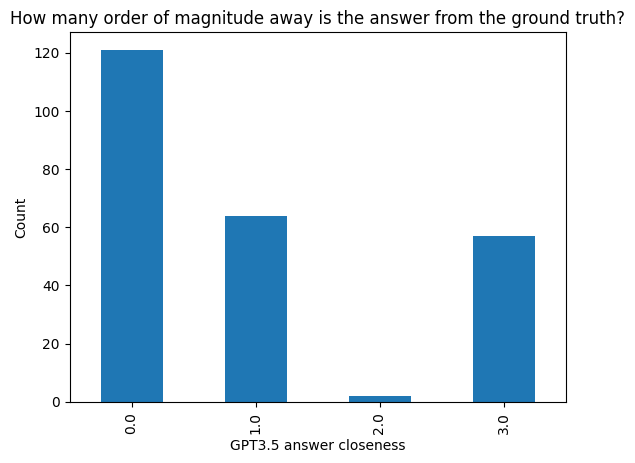

In [109]:
# Define a function to label scores
def label_closeness(score):
    if score > 0.9:
        return 0
    elif score >= 2/3:
        return 1
    elif score >= 1/3:
        return 2
    elif score <= 0.00000001:
        return 3

# Apply the function to the 'score' column to create a new 'label' column
df['label'] = df['Prompt_1_score'].apply(label_closeness)

# Calculate the counts of each label
label_counts = df['label'].value_counts().sort_index()

# Create a bar plot
label_counts.plot(kind='bar')

# Set the title and labels
plt.title('How many order of magnitude away is the answer from the ground truth?')
plt.xlabel('GPT3.5 answer closeness')
plt.ylabel('Count')

# Show the plot
plt.show()

# the plot shows that most of the answers are either 0 or 1 order of magnitude away from the ground truth,
# or more than 2 orders of magnitude away from the ground truth
# this is only a numerical representation of the closeness of the answer to the ground truth,
# not considering the validity of the steps of reasoning

In [ ]:
# if we ask GPT to generate code instead of answer from the text prompt, we maybe able to run the code to get the answer
# we can consider testing on langChain toolkit -> 

## Conclusion
Using simple contextual prompt from LLM without any fine-tuning can result in performance score of 0.634 (pandas). This score is significantly better than previously reported score (0.08-0.12) with best fine-tuned T5 model.

This indicates that instructed-tuned model with human-feedback can handle more complex reasoning and perform Fermi Estimation task much better than SOTA.

The next step is to formalise interaction step-by-step, and design prompts suitable for those tasks.

In [ ]:
# try prompt the language model to performa individual task

## GPT-generated code

In [43]:
# Constants
molar_mass_zinc = 65.38  # g/mol
avogadro_number = 6.022 * 10**23  # particles per mole
proton_charge = 1.602 * 10**-19  # C
mass_penny = 3  # grams
proton_charge_diff = proton_charge*10**-6  # C

# Calculate the number of protons
moles_copper = mass_penny / molar_mass_zinc
number_of_protons = moles_copper * avogadro_number

# Calculate the electric charge
charge = number_of_protons * proton_charge_diff

# Print the result
print("The electric charge of the copper penny is:", charge, "Coulombs")

# coulumb constant
k = 8.99 * 10**9  # Nm^2/C^2
Force = k*charge**2/(1)**2
print("The repel force will be:", Force, "N")


The electric charge of the copper penny is: 0.004426695013765677 Coulombs
The repel force will be: 176164.7024166322 N


In [49]:
# what does PI = 0.375 mean?
# let's say we reached PI = 0.47 for some questions
# compared to PI = 0.13 from SOTA
PI_old = 0.13
PI_new = 0.47 
uncertainty_old = 3*(1-PI_old)
uncertainty_new = 3*(1-PI_new)

PI_diff = 0.43926-0.34517
uncertainty_diff = 3*(PI_diff)
print(10**uncertainty_diff)
# we achieved nearly 1 order of magnitude improvement in uncertainty

1.9154463840681566


In [67]:
# Assumptions
population_us = 330_000_000
bottle_size_ml = 473
bottles_per_day = 1
purchased_ratio = 0.75
days_per_year = 365

# Calculate the number of milliliters of water consumed per day
daily_consumption_ml = population_us * bottle_size_ml * bottles_per_day

# Calculate the number of milliliters of water consumed per year
annual_consumption_ml = daily_consumption_ml * days_per_year

# Calculate the number of milliliters of bottled water purchased/drank per person in the U.S. per year
purchased_consumption_ml = annual_consumption_ml * purchased_ratio

# Print the result
print(f"The estimated value for the number of milliliters of bottled water purchased/drank per person in the U.S. per year is: {purchased_consumption_ml:.2e} milliliters per year.")


The estimated value for the number of milliliters of bottled water purchased/drank per person in the U.S. per year is: 4.27e+13 milliliters per year.


In [71]:
# Assuming we are talking about a single-file line of carbon atoms
carbon_atom_diameter = 69  # in pm (picometers)

# The circumference of the Earth
earth_circumference = 40075  # in kilometers

# Convert Earth's circumference from kilometers to nanometers
earth_circumference_nm = earth_circumference * 1e12  # 1 kilometer = 1,000,000,000,000 picometers

# Calculate the number of carbon atoms needed to create a single-file line around the Earth
num_carbon_atoms = earth_circumference_nm / carbon_atom_diameter
print(num_carbon_atoms)

580797101449275.4
